### This notebook implements Omnifold using a decision tree classifier
#### Fake MC data, simulation data, and measured data is used to test this
#### The results are directly compared to IBU from RooUnfold

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import data_handler as dh
hep.style.use(hep.style.CMS)

### Creating datasets

In [2]:
# There are two different smearing functions that we consider when generating data
# These are taken from the RooUnfold tutorials (github.com/vincecr0ft/RooUnfoldTutorials)
# The two datasets use different binning
smearing_function = "smear"
if smearing_function == "calo":
    sim_bins  = 40
    MC_bins   = 40
    sim_low   = 0
    sim_high  = 10
    MC_low    = 0
    MC_high   = 10
else:
    sim_bins  = 40
    MC_bins   = 40
    sim_low   = -10
    sim_high  = 10
    MC_low    = -10
    MC_high   = 10

In [3]:
MC_hist  = ROOT.TH1D("MC_hist", "MC_hist", MC_bins, MC_low, MC_high)
sim_hist = ROOT.TH1D("sim_hist", "sim_hist", sim_bins, sim_low, sim_high)
response = ROOT.RooUnfoldResponse(sim_bins, sim_low, sim_high, MC_bins, MC_low, MC_high)

In [4]:
num_MC_data_points  = 100000
unbinned_sim_data = []
unbinned_MC_data  = []

In [5]:
for i in range(num_MC_data_points):
  # Generating MC data
  if smearing_function == "calo":
      xt = ROOT.gRandom.BreitWigner(5.0, 1.0)
  else:
      xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  MC_hist.Fill(xt)
  # Smearing the MC data
  x = dh.smearing_wrapper(xt, smearing_function)
  unbinned_MC_data.append(xt)

  if x != None:
    response.Fill(x, xt)
    sim_hist.Fill(x)
    unbinned_sim_data.append(x)
  else:
    # Filling data that appeared in MC but was 'None' in sim dataset
    response.Miss(xt)
    unbinned_sim_data.append(np.nan)

unbinned_sim_data = np.array(unbinned_sim_data, dtype=np.float32)
unbinned_MC_data = np.array(unbinned_MC_data, dtype=np.float32)

In [6]:
# Generating true and measured data
unbinned_true_data     = []
unbinned_measured_data = []

true_hist     = ROOT.TH1D ("true_hist", "true_hist", MC_bins, MC_low, MC_high)
measured_hist = ROOT.TH1D ("measured_hist", "measured_hist", sim_bins, sim_low, sim_high)

for i in range(10000):
    if smearing_function == "calo":
        xt = ROOT.gRandom.Gaus (5.0, 1.0)
    else:
        xt = ROOT.gRandom.Gaus (0.0, 2.0)
    x = dh.smearing_wrapper(xt, smearing_function)
    true_hist.Fill(xt)
    unbinned_true_data.append(xt)
    if x != None:
        measured_hist.Fill(x);
        unbinned_measured_data.append(x)
    
unbinned_true_data = np.array(unbinned_true_data, dtype=np.float32)
unbinned_measured_data = np.array(unbinned_measured_data, dtype=np.float32)

### Unfolding procedure

In [7]:
num_iterations = 4

#### Omnifold function using decision trees

In [8]:
from sklearn import tree
def reweight(events, classifier):
    class_probabilities = classifier.predict_proba(events)
    data_probability = class_probabilities[:,1]
    weights = np.nan_to_num(data_probability / (1. - data_probability))
    return np.squeeze(np.nan_to_num(weights))
        
def omnifold(response, data_hist, num_iterations):
    data_counts, data_bin_centers = dh.TH1_to_numpy(data_hist)

    response_hist = response.HresponseNoOverflow()
    
    response_counts, response_bin_centers = dh.TH2_to_numpy(response_hist)

    MC_entries, sim_entries = dh.prepare_response_data(response_counts.flatten(), response_bin_centers.flatten())
    data_entries = dh.prepare_hist_data(data_counts, data_bin_centers)
    
    sim_labels = np.zeros(len(sim_entries))
    data_labels = np.ones(len(data_entries))
    MC_labels = np.zeros(len(MC_entries))

    step1_data = np.concatenate((sim_entries, data_entries))
    step1_labels = np.concatenate((sim_labels, data_labels))

    step2_data = np.concatenate((MC_entries, MC_entries))
    step2_labels = np.concatenate((MC_labels, np.ones(len(MC_entries))))

    # initial iterative weights are ones
    weights_pull = np.ones(len(sim_entries))
    weights_push = np.ones(len(sim_entries))
    
    for i in range(num_iterations):
        weights_step1 = np.concatenate((weights_push, np.ones(len(data_entries))))
        step1_classifier = tree.DecisionTreeClassifier()
        step1_classifier.fit(step1_data, step1_labels, sample_weight = weights_step1)
        
        weights_pull = np.multiply(weights_push, reweight(sim_entries, step1_classifier))
        weights_step2 = np.concatenate((np.ones(len(MC_entries)), weights_pull))
        step2_classifier = tree.DecisionTreeClassifier()
        step2_classifier.fit(step2_data, step2_labels, sample_weight = weights_step2)
        
        weights_push = reweight(MC_entries, step2_classifier)
    return weights_push, weights_pull, MC_entries

In [9]:
# Getting weights from omnifold
weights_push, weights_pull, MC_entries = omnifold(response, measured_hist, num_iterations)
# Applying weights to MC data
omnifold_dt_hist, omnifold_bin_edges = np.histogram(MC_entries.flatten(), weights = weights_push, bins = MC_bins, range = [MC_low, MC_high])
omnifold_bin_centers = (omnifold_bin_edges[:-1] + omnifold_bin_edges[1:]) / 2

# Accounting for efficiencies
efficiencies = response.Vefficiency()
efficiencies_np = np.empty(efficiencies.GetNoElements())
for i in range(efficiencies.GetNoElements()):
    efficiencies_np[i] = efficiencies[i]
omnifold_dt_hist = np.divide(omnifold_dt_hist, efficiencies_np, out=np.zeros_like(omnifold_dt_hist, dtype=np.float32), where=efficiencies_np!=0)

In [10]:
# Getting IBU results from RooUnfold
IBU_RooUnfold = ROOT.RooUnfoldBayes(response, measured_hist, num_iterations)
hReco_RooUnfold = IBU_RooUnfold.Hunfold()

Using response matrix priors
Priors:

Vector (40)  is as follows

     |        1  |
------------------
   0 |0.00182442 
   1 |0.00239998 
   2 |0.00254116 
   3 |0.00255202 
   4 |0.00327961 
   5 |0.00362712 
   6 |0.00423526 
   7 |0.00485426 
   8 |0.00548412 
   9 |0.00658095 
  10 |0.00825333 
  11 |0.00953477 
  12 |0.0113158 
  13 |0.0149103 
  14 |0.0202641 
  15 |0.0282785 
  16 |0.0373029 
  17 |0.0542874 
  18 |0.082099 
  19 |0.113874 
  20 |0.137874 
  21 |0.121704 
  22 |0.088441 
  23 |0.059967 
  24 |0.0414947 
  25 |0.0282025 
  26 |0.0214044 
  27 |0.0160071 
  28 |0.013075 
  29 |0.00951305 
  30 |0.00807958 
  31 |0.00709135 
  32 |0.00586421 
  33 |0.00466965 
  34 |0.00455019 
  35 |0.00356197 
  36 |0.00362712 
  37 |0.00276921 
  38 |0.0023674 
  39 |0.00223709 

Now unfolding...
Iteration : 0
Chi^2 of change 970.321
Iteration : 1
Chi^2 of change 7.84678
Iteration : 2
Chi^2 of change 1.56566
Iteration : 3
Chi^2 of change 0.843821
Calculating covariances due to

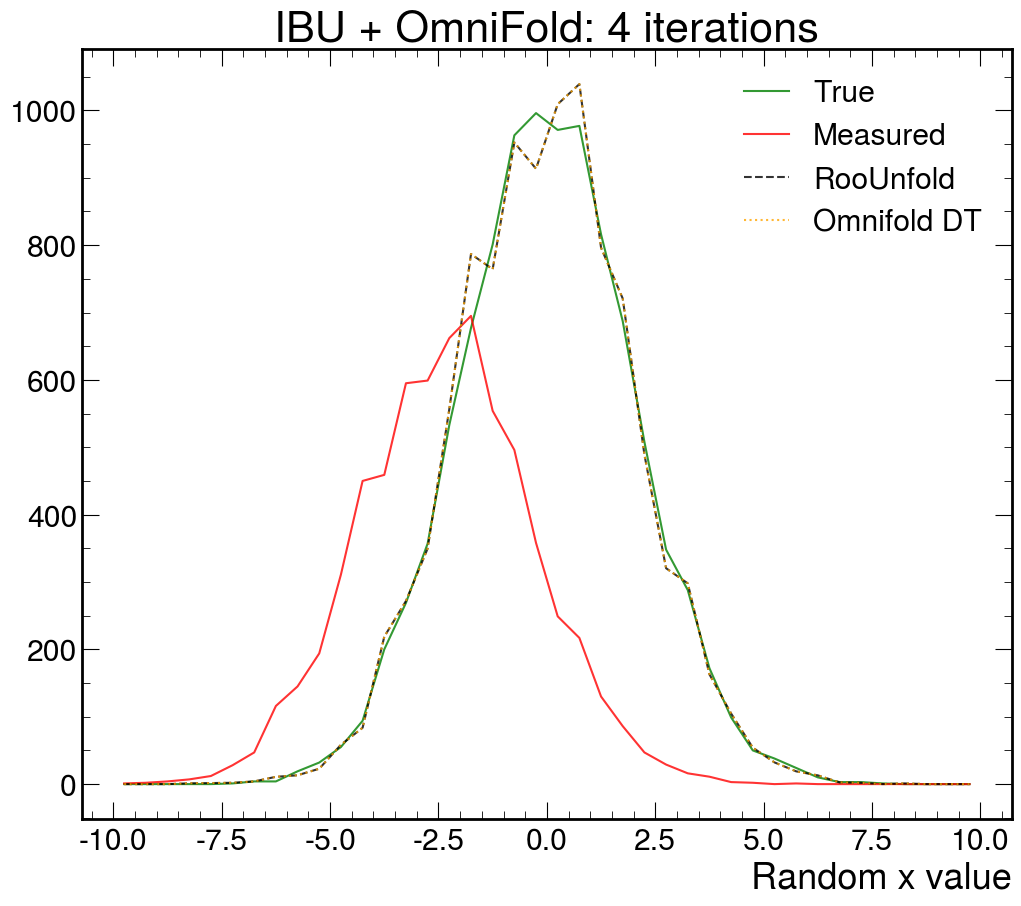

In [11]:
# Plotting our unfolded results
true_data, true_x = dh.TH1_to_numpy(true_hist)
roounfold_data, roounfold_x = dh.TH1_to_numpy(hReco_RooUnfold)
measured_data, measured_x = dh.TH1_to_numpy(measured_hist)

fig = plt.figure(figsize=(12,10))
plt.plot(true_x, true_data, label = "True", color = 'green', alpha = .8)
plt.plot(measured_x, measured_data, label = "Measured", color = 'red', alpha = .8)

plt.plot(roounfold_x, roounfold_data, label = "RooUnfold", color = 'black', linestyle='dashed', alpha = .8)
plt.plot(omnifold_bin_centers, omnifold_dt_hist, label = "Omnifold DT", linestyle='dotted', alpha = .8, color = 'orange')

plt.xlabel("Random x value")
plt.title(f"IBU + OmniFold: {num_iterations} iterations")
plt.legend()
plt.show()